In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Real images found: 52001
Fake images found: 3000


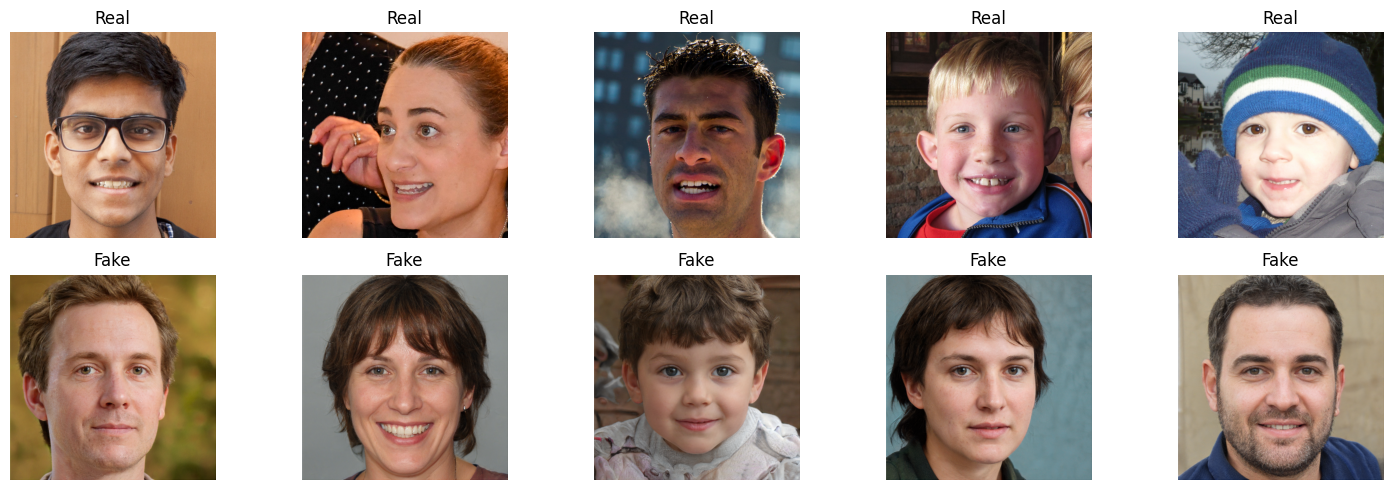

In [ ]:
import os
import random
import kagglehub
import matplotlib.pyplot as plt
from PIL import Image

# Download datasets
real_face_dataset = kagglehub.dataset_download("arnaud58/flickrfaceshq-dataset-ffhq")
fake_face_dataset = kagglehub.dataset_download("shavaizbutt/ai-face-dataset-3000-images")

# List .png files
real_all_images = [f for f in os.listdir(real_face_dataset) if f.endswith('.png')]
fake_images = [f for f in os.listdir(fake_face_dataset) if f.endswith('.png')]

print(f"Real images found: {len(real_all_images)}")
print(f"Fake images found: {len(fake_images)}")

# Randomly select 3000 real images
real_images = random.sample(real_all_images, 3000)

# Pick 5 to display
sample_real = random.sample(real_images, 5)
sample_fake = random.sample(fake_images, 5)

# Display side-by-side
plt.figure(figsize=(15, 5))

# Show real images
for i, image_file in enumerate(sample_real):
    image_path = os.path.join(real_face_dataset, image_file)
    image = Image.open(image_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Real")

# Show fake images
for i, image_file in enumerate(sample_fake):
    image_path = os.path.join(fake_face_dataset, image_file)
    image = Image.open(image_path)
    plt.subplot(2, 5, 5 + i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Fake")

plt.tight_layout()
plt.show()

In [ ]:
!pip install transformers torch torchvision
!pip install datasets accelerate
!pip install pillow scikit-learn matplotlib seaborn

In [ ]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoImageProcessor, AutoModel, TrainingArguments, Trainer
from transformers import ViTForImageClassification, ViTImageProcessor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Create custom dataset class for transformers
class DeepfakeDataset(Dataset):
    def __init__(self, image_paths, labels, processor, image_size=(224, 224)):
        self.image_paths = image_paths
        self.labels = labels
        self.processor = processor
        self.image_size = image_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load and process image
        try:
            image = Image.open(self.image_paths[idx]).convert('RGB')
            image = image.resize(self.image_size)

            # Use the processor to prepare the image for the model
            processed = self.processor(images=image, return_tensors="pt")
            pixel_values = processed['pixel_values'].squeeze(0)

            return {
                'pixel_values': pixel_values,
                'labels': torch.tensor(self.labels[idx], dtype=torch.long)
            }
        except Exception as e:
            print(f"Error loading image {self.image_paths[idx]}: {e}")
            # Return a black image if there's an error
            black_image = Image.new('RGB', self.image_size, (0, 0, 0))
            processed = self.processor(images=black_image, return_tensors="pt")
            pixel_values = processed['pixel_values'].squeeze(0)

            return {
                'pixel_values': pixel_values,
                'labels': torch.tensor(self.labels[idx], dtype=torch.long)
            }

In [ ]:
# Prepare your data (modify paths according to your setup)

# Initialize lists for all image paths and labels
all_image_paths = []
all_labels = []

# Add real images (label: 1)
for img_file in real_images:
    img_path = os.path.join(real_face_dataset, img_file)
    if os.path.exists(img_path):
        all_image_paths.append(img_path)
        all_labels.append(1)

# Add fake images (label: 0)
for img_file in fake_images:
    img_path = os.path.join(fake_face_dataset, img_file)
    if os.path.exists(img_path):
        all_image_paths.append(img_path)
        all_labels.append(0)

print(f"Total images: {len(all_image_paths)}")
print(f"Real images: {sum(all_labels)}")
print(f"Fake images: {len(all_labels) - sum(all_labels)}")

# Convert to numpy arrays
all_image_paths = np.array(all_image_paths)
all_labels = np.array(all_labels)

Total images: 6000
Real images: 3000
Fake images: 3000


In [ ]:
# Split data into train, validation, and test sets

X_train_val, X_test, y_train_val, y_test = train_test_split(
    all_image_paths, all_labels,
    test_size=0.2,
    random_state=42,
    stratify=all_labels
)

# Second split: separate train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.25,  # 0.25 * 0.8 = 0.2 of total data
    random_state=42,
    stratify=y_train_val
)

print(f"Training set: {len(X_train)} images")
print(f"Validation set: {len(X_val)} images")
print(f"Test set: {len(X_test)} images")
print(f"Training - Real: {sum(y_train)}, Fake: {len(y_train) - sum(y_train)}")
print(f"Validation - Real: {sum(y_val)}, Fake: {len(y_val) - sum(y_val)}")
print(f"Test - Real: {sum(y_test)}, Fake: {len(y_test) - sum(y_test)}")

Training set: 3600 images
Validation set: 1200 images
Test set: 1200 images
Training - Real: 1800, Fake: 1800
Validation - Real: 600, Fake: 600
Test - Real: 600, Fake: 600


In [ ]:
# Load pre-trained Vision Transformer model
model_name = "google/vit-base-patch16-224"

# Load the image processor
processor = ViTImageProcessor.from_pretrained(model_name)

# Load the model for binary classification, ignoring size mismatches in the final layer
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=2,  # Binary classification: real vs fake
    id2label={0: "fake", 1: "real"},
    label2id={"fake": 0, "real": 1},
    ignore_mismatched_sizes=True # Ignore size mismatch for the classification head
)

print(f"Model loaded: {model_name}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded: google/vit-base-patch16-224
Model parameters: 85,800,194
Trainable parameters: 85,800,194


In [ ]:
# Create dataset objects
train_dataset = DeepfakeDataset(X_train, y_train, processor)
val_dataset = DeepfakeDataset(X_val, y_val, processor)
test_dataset = DeepfakeDataset(X_test, y_test, processor)

print("Datasets created successfully!")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Test loading one sample
sample = train_dataset[0]
print(f"Sample pixel values shape: {sample['pixel_values'].shape}")
print(f"Sample label: {sample['labels']}")

Datasets created successfully!
Train dataset size: 3600
Validation dataset size: 1200
Test dataset size: 1200
Sample pixel values shape: torch.Size([3, 224, 224])
Sample label: 0


In [ ]:
# Define evaluation metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)

    return {
        'accuracy': accuracy,
    }

# Optional: Custom data collator if needed
def collate_fn(batch):
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    labels = torch.stack([item['labels'] for item in batch])

    return {
        'pixel_values': pixel_values,
        'labels': labels
    }

In [ ]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir='./deepfake_detection_results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to=None,
    dataloader_num_workers=2,
)

print("Training arguments set!")
print(f"Total epochs: {training_args.num_train_epochs}")
print(f"Train batch size: {training_args.per_device_train_batch_size}")
print(f"Eval batch size: {training_args.per_device_eval_batch_size}")

Training arguments set!
Total epochs: 3
Train batch size: 16
Eval batch size: 16


In [ ]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

print("Trainer initialized!")
print("Ready to start training...")

Trainer initialized!
Ready to start training...


In [ ]:
# Start training
print("Starting training...")
print("This may take a while depending on your dataset size and hardware.")

# Train the model
trainer.train()

print("Training completed!")

save_path = '/content/drive/My Drive/deepfake_detection/models/deepfake_model_transformer'

# Save the final model and processor
trainer.save_model(save_path)
processor.save_pretrained(save_path)

print(f"Model saved to '{save_path}'")

Starting training...
This may take a while depending on your dataset size and hardware.


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: tishanshamika200 (tishanshamika200-university-of-ruhuna) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy
100,0.008600,0.140431,0.955000
200,0.038100,0.032060,0.988333
300,0.000200,0.011477,0.995833
400,0.000400,0.005945,0.998333
500,0.000400,0.006461,0.998333
600,0.000200,0.004426,0.998333


Error loading image /root/.cache/kagglehub/datasets/shavaizbutt/ai-face-dataset-3000-images/versions/1/seed111370.png: unrecognized data stream contents when reading image file
Error loading image /root/.cache/kagglehub/datasets/shavaizbutt/ai-face-dataset-3000-images/versions/1/seed111380.png: unrecognized data stream contents when reading image file
Error loading image /root/.cache/kagglehub/datasets/shavaizbutt/ai-face-dataset-3000-images/versions/1/seed111695.png: broken data stream when reading image file
Error loading image /root/.cache/kagglehub/datasets/shavaizbutt/ai-face-dataset-3000-images/versions/1/seed111370.png: unrecognized data stream contents when reading image file
Error loading image /root/.cache/kagglehub/datasets/shavaizbutt/ai-face-dataset-3000-images/versions/1/seed111695.png: broken data stream when reading image file
Error loading image /root/.cache/kagglehub/datasets/shavaizbutt/ai-face-dataset-3000-images/versions/1/seed111370.png: unrecognized data stream c

In [ ]:
# Evaluate on test set
print("Evaluating on test set...")

# Evaluate the model
test_results = trainer.evaluate(test_dataset)

print("Test Results:")
for key, value in test_results.items():
    print(f"{key}: {value:.4f}")

# Get predictions for detailed analysis
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Calculate detailed metrics
test_accuracy = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Fake', 'Real']))

Evaluating on test set...


Test Results:
eval_loss: 0.0010
eval_accuracy: 0.9992
eval_runtime: 43.4677
eval_samples_per_second: 27.6070
eval_steps_per_second: 1.7250
epoch: 3.0000

Test Accuracy: 0.9992

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00       600
        Real       1.00      1.00      1.00       600

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



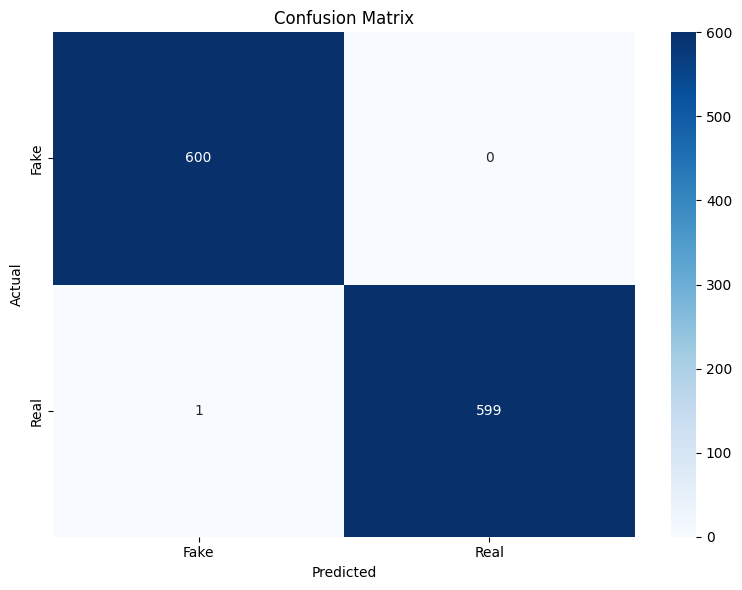

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'Real'],
            yticklabels=['Fake', 'Real'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Calculate and print additional metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

In [ ]:
# Create inference function for new images
def predict_single_image(image_path, model, processor, device='cpu'):
    """
    Predict if a single image is real or fake.

    Args:
        image_path: Path to the image file
        model: Trained model
        processor: Image processor
        device: Device to run inference on

    Returns:
        prediction: 'real' or 'fake'
        confidence: Confidence score
    """
    try:
        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        inputs = processor(images=image, return_tensors="pt")

        # Move to device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Make prediction
        model.eval()
        with torch.no_grad():
            outputs = model(**inputs)
            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
            predicted_class_id = predictions.argmax().item()
            confidence = predictions.max().item()

        # Convert prediction to label
        prediction = "real" if predicted_class_id == 1 else "fake"

        return prediction, confidence

    except Exception as e:
        print(f"Error predicting image {image_path}: {e}")
        return None, None

# Move model to device for inference
model.to(device)

print("Inference function created!")

Inference function created!


In [ ]:
# Test inference on a few test images
print("Testing inference on sample images...")

# Test on a few random test images
import random
test_indices = random.sample(range(len(X_test)), min(5, len(X_test)))

for i, idx in enumerate(test_indices):
    image_path = X_test[idx]
    true_label = "real" if y_test[idx] == 1 else "fake"

    prediction, confidence = predict_single_image(image_path, model, processor, device)

    if prediction is not None:
        print(f"\nImage {i+1}: {os.path.basename(image_path)}")
        print(f"True label: {true_label}")
        print(f"Predicted: {prediction}")
        print(f"Confidence: {confidence:.4f}")
        print(f"Correct: {'✓' if prediction == true_label else '✗'}")
    else:
        print(f"Failed to process image {i+1}")

Testing inference on sample images...

Image 1: 04542.png
True label: real
Predicted: real
Confidence: 0.9999
Correct: ✓

Image 2: 51129.png
True label: real
Predicted: real
Confidence: 0.9999
Correct: ✓

Image 3: 41465.png
True label: real
Predicted: real
Confidence: 1.0000
Correct: ✓

Image 4: 49265.png
True label: real
Predicted: real
Confidence: 0.9999
Correct: ✓

Image 5: 21001.png
True label: real
Predicted: real
Confidence: 1.0000
Correct: ✓


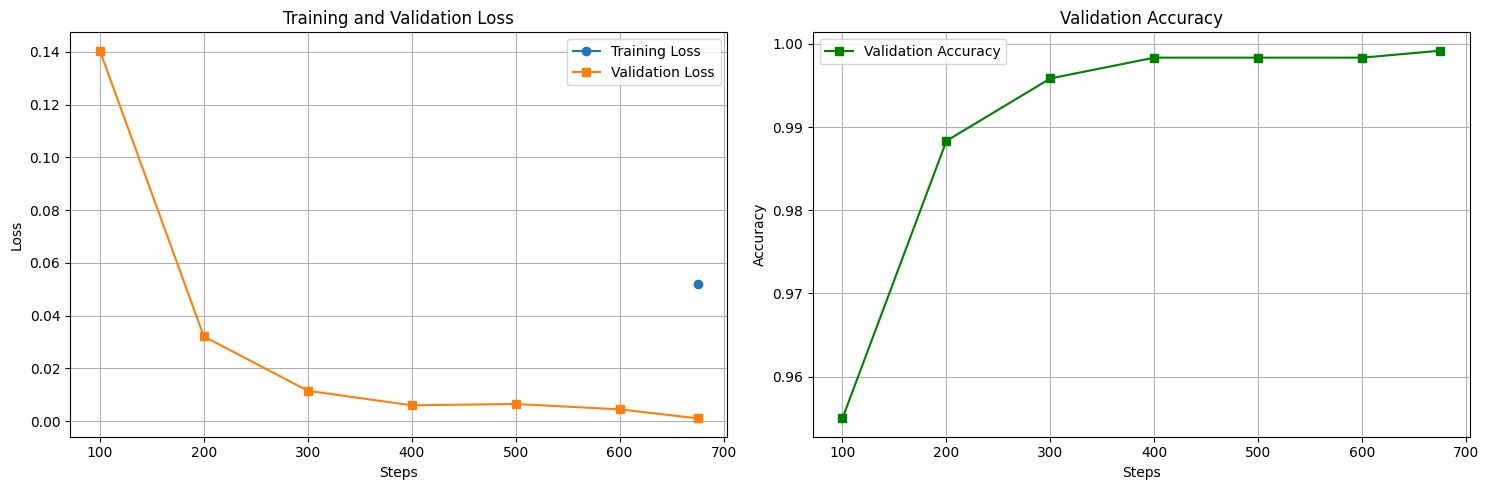

In [ ]:
# Plot training history
try:
    # Get training history from trainer
    log_history = trainer.state.log_history

    # Extract training and validation metrics
    train_loss = [log['train_loss'] for log in log_history if 'train_loss' in log]
    eval_loss = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
    eval_accuracy = [log['eval_accuracy'] for log in log_history if 'eval_accuracy' in log]

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    if train_loss and eval_loss:
        steps_train = [log['step'] for log in log_history if 'train_loss' in log]
        steps_eval = [log['step'] for log in log_history if 'eval_loss' in log]

        ax1.plot(steps_train, train_loss, label='Training Loss', marker='o')
        ax1.plot(steps_eval, eval_loss, label='Validation Loss', marker='s')
        ax1.set_xlabel('Steps')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.legend()
        ax1.grid(True)

    # Plot accuracy
    if eval_accuracy:
        steps_eval = [log['step'] for log in log_history if 'eval_accuracy' in log]
        ax2.plot(steps_eval, eval_accuracy, label='Validation Accuracy', marker='s', color='green')
        ax2.set_xlabel('Steps')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Validation Accuracy')
        ax2.legend()
        ax2.grid(True)

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Could not plot training history: {e}")
    print("This might happen if training was too short or logs weren't saved properly.")

In [ ]:
# Load saved model and create Gradio interface
!pip install gradio

import gradio as gr
import numpy as np
import torch
from PIL import Image
import torch.nn.functional as F
from transformers import ViTForImageClassification, ViTImageProcessor

# Load the saved model and processor
def load_saved_model(model_path='./deepfake_detection_final'):
    """
    Load the saved model and processor.
    """
    try:
        model = ViTForImageClassification.from_pretrained(model_path)
        processor = ViTImageProcessor.from_pretrained(model_path)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)
        print(f"Model loaded successfully from {model_path}")
        print(f"Using device: {device}")
        return model, processor, device
    except Exception as e:
        print(f"Error loading model: {e}")
        return None, None, None

# Load model (uncomment this if you want to load from saved files)
# model, processor, device = load_saved_model()

def classify_image(image):
    """
    Classify an uploaded image as real or fake.
    """
    try:
        # Convert numpy array to PIL Image
        if isinstance(image, np.ndarray):
            if image.dtype == np.float64 or image.dtype == np.float32:
                image = (image * 255).astype(np.uint8)
            elif image.dtype != np.uint8:
                image = image.astype(np.uint8)

            if len(image.shape) == 3 and image.shape[2] == 3:
                pil_image = Image.fromarray(image, 'RGB')
            elif len(image.shape) == 3 and image.shape[2] == 4:
                pil_image = Image.fromarray(image, 'RGBA').convert('RGB')
            else:
                pil_image = Image.fromarray(image).convert('RGB')
        else:
            pil_image = image

        # Preprocess the image
        inputs = processor(images=pil_image, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Make prediction
        model.eval()
        with torch.no_grad():
            outputs = model(**inputs)
            probabilities = F.softmax(outputs.logits, dim=-1).cpu().numpy()[0]

        # Get prediction and confidence
        predicted_class = "Real" if probabilities[1] > probabilities[0] else "Fake"
        confidence = max(probabilities)

        results = {
            "Fake": float(probabilities[0]),
            "Real": float(probabilities[1])
        }

        # Print results for debugging
        print(f"Prediction: {predicted_class} (Confidence: {confidence:.3f})")

        return results

    except Exception as e:
        print(f"Error in classification: {e}")
        return {"Error": 1.0, "Unable to classify": 0.0}

# Create enhanced Gradio interface
def create_interface():
    """
    Create and return the Gradio interface.
    """
    with gr.Blocks(theme=gr.themes.Soft(), title="Deepfake Detector") as interface:

        gr.Markdown("""
        # 🔍 Deepfake Detection Model

        Upload an image to classify whether it is **real** or **AI-generated/deepfake**.

        This model uses a Vision Transformer (ViT) fine-tuned specifically for deepfake detection.
        """)

        with gr.Row():
            with gr.Column():
                image_input = gr.Image(
                    type="numpy",
                    label="📁 Upload Image",
                    height=300
                )

                classify_btn = gr.Button(
                    "🔍 Analyze Image",
                    variant="primary",
                    size="lg"
                )

            with gr.Column():
                output_label = gr.Label(
                    num_top_classes=2,
                    label="📊 Classification Results"
                )

                gr.Markdown("""
                ### 📖 How to interpret results:
                - **Real**: The image appears to be authentic/genuine
                - **Fake**: The image appears to be AI-generated or manipulated
                - **Confidence scores** show the model's certainty (higher = more confident)
                """)

        # Connect the button to the function
        classify_btn.click(
            fn=classify_image,
            inputs=image_input,
            outputs=output_label
        )

        # Also allow clicking on the image to classify
        image_input.upload(
            fn=classify_image,
            inputs=image_input,
            outputs=output_label
        )

        gr.Markdown("""
        ---
        **Note**: This is a demonstration model. Results should be used as guidance only.
        Always verify important findings through multiple sources and methods.
        """)

    return interface

# Create and launch interface
if __name__ == "__main__":
    print("Setting up Gradio interface...")

    # Check if model variables exist
    try:
        # Test if model and processor are accessible
        test_image = Image.new('RGB', (224, 224), (128, 128, 128))
        test_inputs = processor(images=test_image, return_tensors="pt")
        print("Model and processor are ready!")

        # Create and launch interface
        iface = create_interface()
        iface.launch(
            share=True,      # Creates a public link
            debug=True,      # Show debug info
            show_error=True, # Show errors in interface
            inbrowser=True,  # Auto-open in browser
            height=600       # Interface height
        )

    except NameError:
        print("Model or processor variables not found!")
        print("Please run the training cells first, or uncomment the model loading section above.")
    except Exception as e:
        print(f"Error setting up interface: {e}")
        print("Make sure the model is trained and loaded properly.")

Setting up Gradio interface...
Model and processor are ready!
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://ba068f9b3a06ef2ed0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://ba068f9b3a06ef2ed0.gradio.live
